In [1]:
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup

import torch
from transformers import BertTokenizer, BertModel
from datetime import datetime

import matplotlib.pyplot as plt

import multiprocessing as mp

from bert_serving.client import BertClient

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

In [2]:
import embed_json

loading bert model...


In [7]:
websites = ['www.epfl.ch/en', 
            'www.epfl.ch/fr',
            'www.caltech.edu/', 
            'www.bbc.com', 
            'www.foxnews.com', 
            'www.skysports.com/', 
            'www.redbull.com/int-en/',
            'www.apple.com/', 
            'www.samsung.com/us/', 
            'www.samsung.com/fr/',
            'www.huawei.com/us/',
            'democrats.org/', 
            'www.spd.de',
            'www.parti-socialiste.fr/', 
            'www.nzz.ch/']

websites_html = [requests.get('https://' + url).text for url in websites]

In [8]:
websites_sent = [embed_json.bert_split(body) for body in websites_html]

In [9]:
for w in websites_sent:
    print(len(w))
    print(w[:20])

7308
['École polytechnique fédérale de Lausanne EPFL', 'Skip to content', 'About', 'Education', 'Research', 'Innovation', 'Schools', 'Campus', 'Coronavirus Info', 'Search on the site', 'Validate', 'Show hide the search form', 'Search on the site', 'Hide the search form', 'FR', 'EN', 'Menu', 'Data centers need to consider their carbon footprint', 'News', 'EPFL']
7211
['École polytechnique fédérale de Lausanne EPFL', 'Aller directement au contenu', 'À propos', 'Éducation', 'Recherche', 'Innovation', 'Facultés', 'Campus', 'Info coronavirus', 'Rechercher sur le site', 'Valider', 'Afficher masquer le formulaire de recherche', 'Rechercher sur le site', 'Masquer le formulaire de recherche', 'FR', 'EN', 'Menu', 'Les centres de données contraints de penser leur empreinte carbone', 'Actualités', 'EPFL']
469
['Home www', 'caltech', 'edu', 'Skip to main content', 'Visit', 'Careers', 'Access', 'Quick Links', 'Click here to open the Quick Links submenu', 'for Faculty', 'for Students', 'for Staff', '

In [45]:
bc = BertClient(ip='iccluster037.iccluster.epfl.ch', check_length=False)

In [46]:
websites_emb = [embed_json.bert_embed_html(w, server=True, bc=bc) for w in websites_html]

In [48]:
a = bc.encode(['one', 'two'])

In [51]:
a.mean(axis=0).shape

(768,)

In [15]:
mean = [w[:768] for w in websites_emb]

In [16]:
max = [w[768:] for w in websites_emb]

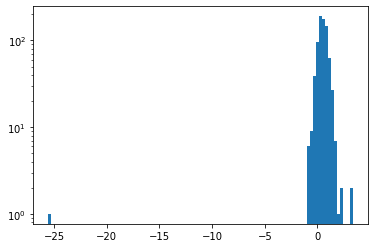

In [19]:
plt.hist(max[4], bins=100)
plt.yscale('log')
plt.show()

In [20]:
for e in max:
    i = np.argmin(e)
    print(i)
    print(e[i])

227
-26.22064
227
-25.833263
227
-25.302494
227
-24.703625
227
-25.542166
227
-25.595663
227
-25.78417
227
-26.479937
227
-25.729826
227
-26.018204
227
-26.133802
227
-25.673971
227
-26.093792
227
-23.820747
227
-25.207228


In [21]:
max_red = [np.delete(w, 227) for w in max]
mean_red = [np.delete(w, 227) for w in mean]

In [22]:
for e in max_red:
    i = np.argmin(e)
    print(i)
    print(e[i])

366
-1.0674975
366
-0.9595745
366
-1.0720962
366
-0.7667567
366
-0.99304277
119
-0.9288093
366
-0.92162514
22
-1.0224432
366
-0.91800547
366
-0.95768625
366
-1.2052504
366
-0.9243117
366
-1.0127941
505
-0.9752928
366
-0.941278


In [25]:
sim = cosine_similarity(max)

In [26]:
for i in range(len(websites)):
    ix = sim[i].argsort()[-3:][1::-1]
    print('closest to {:<23} : {:>23} ({:.4f}), {:>23} ({:.4f})'.format(websites[i][:22], 
                                                           websites[ix[0]][:22],
                                                           sim[ix[0], i],
                                                           websites[ix[1]][:22],
                                                           sim[ix[1], i]))

closest to www.epfl.ch/en          :        www.caltech.edu/ (0.9962),     www.samsung.com/us/ (0.9935)
closest to www.epfl.ch/fr          :     www.samsung.com/fr/ (0.9941),          www.epfl.ch/en (0.9882)
closest to www.caltech.edu/        :          www.epfl.ch/en (0.9962),         www.foxnews.com (0.9921)
closest to www.bbc.com             :         www.foxnews.com (0.9948),  www.redbull.com/int-en (0.9943)
closest to www.foxnews.com         :  www.redbull.com/int-en (0.9963),             www.bbc.com (0.9948)
closest to www.skysports.com/      :         www.foxnews.com (0.9937),  www.redbull.com/int-en (0.9932)
closest to www.redbull.com/int-en  :         www.foxnews.com (0.9963),     www.samsung.com/us/ (0.9955)
closest to www.apple.com/          :      www.huawei.com/us/ (0.9930),     www.samsung.com/us/ (0.9916)
closest to www.samsung.com/us/     :  www.redbull.com/int-en (0.9955),         www.foxnews.com (0.9944)
closest to www.samsung.com/fr/     :          www.epfl.ch/fr (0.

In [27]:
from sklearn.preprocessing import normalize

websites_emb_norm = normalize(websites_emb, axis=0)

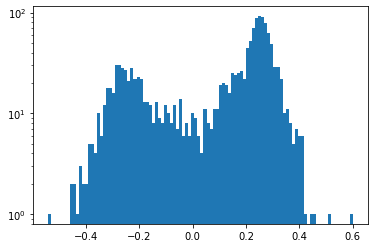

In [33]:
plt.hist(websites_emb_norm[0], bins=100)
plt.yscale('log')
plt.show()

In [34]:
sim = cosine_similarity(websites_emb_norm)

In [35]:
for i in range(len(websites)):
    ix = sim[i].argsort()[-3:][1::-1]
    print('closest to {:<23} : {:>23} ({:.4f}), {:>23} ({:.4f})'.format(websites[i][:22], 
                                                           websites[ix[0]][:22],
                                                           sim[ix[0], i],
                                                           websites[ix[1]][:22],
                                                           sim[ix[1], i]))

closest to www.epfl.ch/en          :        www.caltech.edu/ (0.9357),     www.samsung.com/us/ (0.8812)
closest to www.epfl.ch/fr          :     www.samsung.com/fr/ (0.9110),          www.epfl.ch/en (0.8326)
closest to www.caltech.edu/        :          www.epfl.ch/en (0.9357),         www.foxnews.com (0.8655)
closest to www.bbc.com             :         www.foxnews.com (0.9158),  www.redbull.com/int-en (0.9041)
closest to www.foxnews.com         :  www.redbull.com/int-en (0.9365),             www.bbc.com (0.9158)
closest to www.skysports.com/      :  www.redbull.com/int-en (0.8879),         www.foxnews.com (0.8847)
closest to www.redbull.com/int-en  :         www.foxnews.com (0.9365),     www.samsung.com/us/ (0.9208)
closest to www.apple.com/          :     www.samsung.com/us/ (0.8941),      www.huawei.com/us/ (0.8825)
closest to www.samsung.com/us/     :  www.redbull.com/int-en (0.9208),          www.apple.com/ (0.8941)
closest to www.samsung.com/fr/     :          www.epfl.ch/fr (0.